Facial Recognition (Happy or Anger)
In the code below I use a pretrained model, MobileNetV2, to train emotion detection on faces. The dataset was taken from kaggle. Images are RGB and 96 x 96. 
https://www.kaggle.com/datasets/noamsegal/affectnet-training-data/data

All the same steps were taken as my code with rock papper scissors.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import cv2

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix



In [2]:
#Batch size is low to act as a reguralization
batch_size = 16
folder_dir = r'C:\Users\Hanss\Documents\Utbildning\Deep Learning\Emotional_Recognition_Dataset'
AUTOTUNE = tf.data.AUTOTUNE

train_ds = image_dataset_from_directory(
    folder_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    
    shuffle=True,
    pad_to_aspect_ratio=True,
    interpolation = "bilinear"
)
val_ds = image_dataset_from_directory(
    folder_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    
    pad_to_aspect_ratio=True,
    interpolation = "bilinear"
)

class_names = train_ds.class_names
print(class_names)

Found 8262 files belonging to 2 classes.
Using 6610 files for training.
Found 8262 files belonging to 2 classes.
Using 1652 files for validation.
['anger', 'happy']


In [3]:

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [4]:
class_names = os.listdir(folder_dir)
class_counts = {}

for class_name in class_names:
    class_dir = os.path.join(folder_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    class_counts[class_name] = num_samples

print("Class Counts:", class_counts)

Class Counts: {'anger': 3218, 'happy': 5044}


In [5]:
# weights calculated because there is inbalance between the two classes
total_samples = sum(class_counts.values())
num_classes = len(class_names)
class_weights = {}

for class_name, count in class_counts.items():
    class_index = class_names.index(class_name)
    class_weights[class_index] = total_samples / (num_classes * count)

print("Class Weights:", class_weights)

Class Weights: {0: 1.283716594157862, 1: 0.8189928628072958}


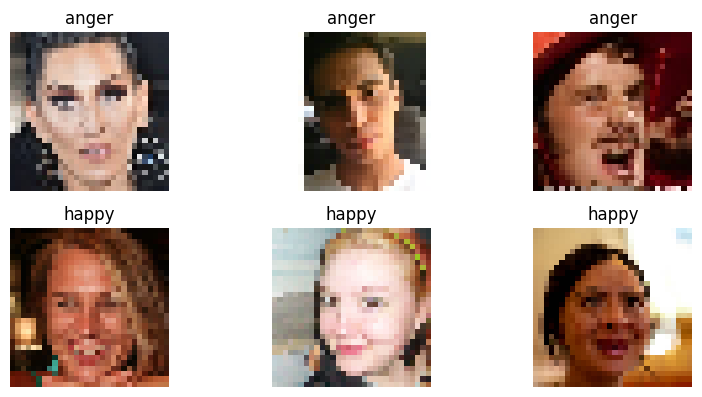

In [6]:
class_names = [name for name in os.listdir(folder_dir) if os.path.isdir(os.path.join(folder_dir, name))]
class_images = {class_name: [] for class_name in class_names}

for class_name in class_images.keys():
    class_path = os.path.join(folder_dir, class_name)
    image_files = sorted(os.listdir(class_path))[:3]  
    for image_file in image_files:
        class_images[class_name].append(os.path.join(class_path, image_file))


plt.figure(figsize=(8, 8))

for i, (class_name, images) in enumerate(class_images.items()):
    for j, image_path in enumerate(images):
        img = load_img(image_path, target_size=(30, 30))  
        plt.subplot(4, 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
data_augmentation = Sequential([
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.3),
    layers.RandomZoom(0.2)  
    ])

In [8]:
base_model = MobileNetV2(input_shape=(224,224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  

# Note: tested unfreezing a layer, come back at a later time
#for layer in base_model.layers[-1:]:  
   # layer.trainable = True

model = Sequential([
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])


optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001)
checkpoint = ModelCheckpoint("emotional_model_best.keras", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_ds,
    class_weight = class_weights,
    validation_data=val_ds,
    epochs=10,
    callbacks =[checkpoint, early_stopping]
    )


Epoch 1/10


414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4543 - loss: 1.5714
Epoch 1: val_loss improved from inf to 0.69148, saving model to emotional_model_best.keras
414/414 ━━━━━━━━━━━━━━━━━━━━ 113s 226ms/step - accuracy: 0.4544 - loss: 1.5707 - val_accuracy: 0.6241 - val_loss: 0.6915
Epoch 2/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5603 - loss: 1.1332
Epoch 2: val_loss improved from 0.69148 to 0.61899, saving model to emotional_model_best.keras
414/414 ━━━━━━━━━━━━━━━━━━━━ 83s 201ms/step - accuracy: 0.5603 - loss: 1.1332 - val_accuracy: 0.6834 - val_loss: 0.6190
Epoch 3/10
413/414 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.5777 - loss: 1.1047
Epoch 3: val_loss improved from 0.61899 to 0.58366, saving model to emotional_model_best.keras
414/414 ━━━━━━━━━━━━━━━━━━━━ 83s 200ms/step - accuracy: 0.5778 - loss: 1.1044 - val_accuracy: 0.6967 - val_loss: 0.5837
Epoch 4/10
414/414 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5823 - loss: 1.0635
Epoch 4: val_loss

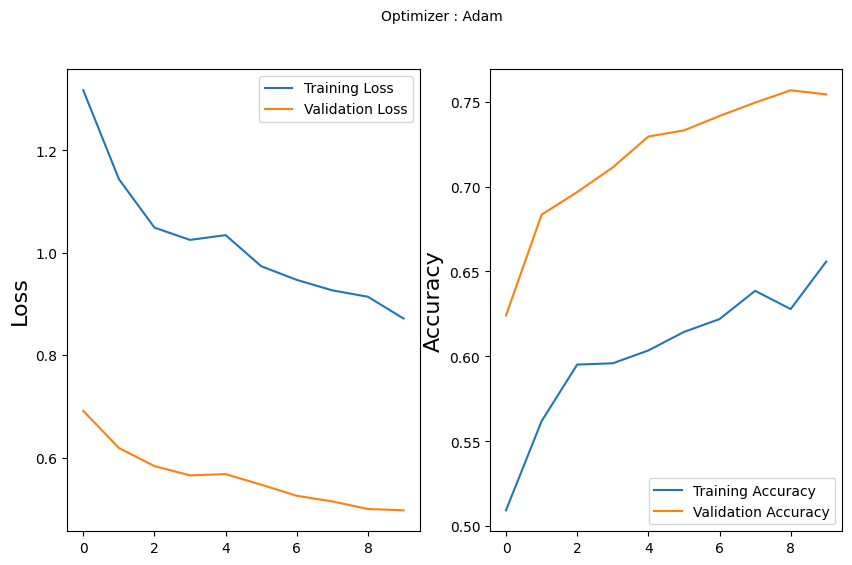

In [13]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms

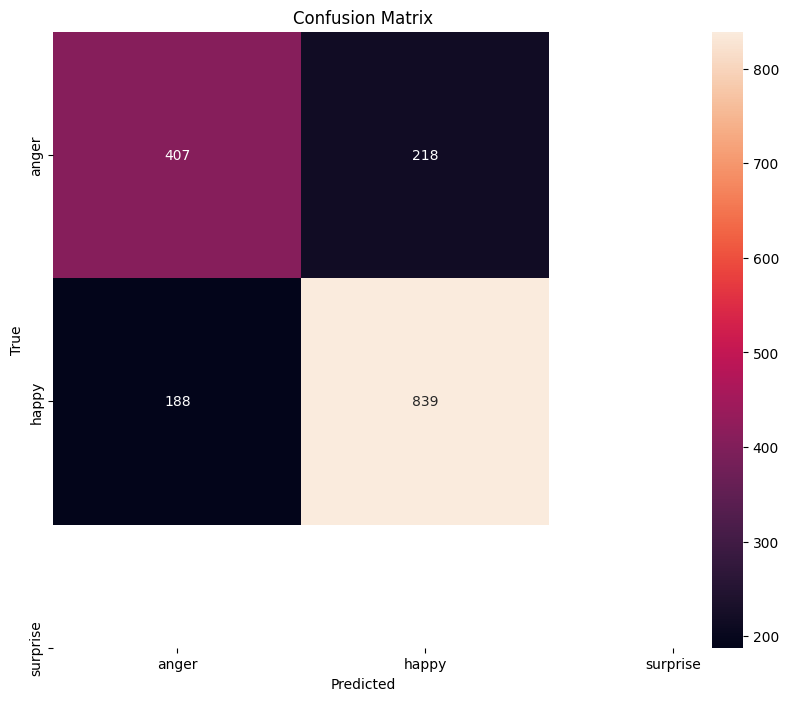

In [17]:
# Confusion matrix Making predictions on the validation dataset
emotion_labels = ['anger','happy', 'surprise']
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())  
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:

classifier = load_model('emotional_model_best.keras')

emotion_labels = ['anger', 'happy']

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
  ret, frame = cap.read()
  if not ret:
    break

  
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  faces = face_classifier.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

  for (x, y, w, h) in faces:
    
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)

    
    face_roi = frame[y:y+h, x:x+w]
    if face_roi.size > 0:
      
      face_roi = cv2.resize(face_roi, (96, 96))
      face_roi = cv2.resize(face_roi, (224, 224), interpolation=cv2.INTER_LINEAR)
      face_roi = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
      face_roi = img_to_array(face_roi)
      face_roi = np.expand_dims(face_roi, axis=0)
      

      
      prediction = classifier.predict(face_roi)[0]
      label_index = np.argmax(prediction)  
      label = emotion_labels[label_index]

      
      label_position = (x, y - 10)
      cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

      
     

  cv2.imshow('Emotion Detector', frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

Results: The model performed adequately, showing reasonable accuracy during both training and validation. However, the confusion matrix indicated some misclassifications. To improve the model's performance, further augmentation and refinement are necessary. Additional data augmentation techniques, such as varying lighting conditions, backgrounds, and facial expressions, can help make the model more robust. Additionally, fine-tuning the model's architecture and hyperparameters, will likely enhance its accuracy and generalization capabilities. Overall, while the model works reasonably well in its current state, there is significant room for improvement to achieve more reliable emotion detection in various real-world scenarios.